# SigOpt's Mouse in a Maze Experimentation Notebook

This notebook walks through the computation described in our blog post SigOpt In Depth: Building a Better Mousetrap via Multicriteria Bayesian Optimization.

These commands will not immediately recreate the blog post images (those experiments take quite a long time) but these tools could be used to that end.  Instead, the numbers input here are at a much more reasonable level from a computational standpoint, while still presenting the structure of the multicriteria experiments.

In [1]:
from sigopt_maze_analysis import (
    SigOptMazeFrontierSolver,
    SigOptMazeWeightedSumFrontierSolver,
    SigOptMazeConstraintFrontierSolver,
    find_pareto_efficient_mean_sd_vecs,
    plot_pareto_frontier,
)
%matplotlib inline  # Omit if you prefer windowed plots, but you will have to run matplotlib.pyplot.show()

We start by choosing a number of maze generation/solution experiments to be run with which the mean and standard deviation will be estimated.  A higher number produces more accurate estimates but will require more time to run.

In [13]:
num_tests = 100

This first test shows how a quasi-random sampling of the domain can produce an initial understanding of the problem at hand, but a mediocre approximation to the Pareto frontier, given the low number of points which are sampled.  Many of the sampled points end up quite far from the Pareto frontier.

In [10]:
basic_tool = SigOptMazeFrontierSolver(num_tests=num_tests)
results_qrandom = basic_tool.execute_low_discrepancy_testing(70, verbose=True)

    0 iterations completed,  3.6 seconds since last report
   10 iterations completed, 38.3 seconds since last report
   20 iterations completed, 41.4 seconds since last report
   30 iterations completed, 39.0 seconds since last report
   40 iterations completed, 39.1 seconds since last report
   50 iterations completed, 39.5 seconds since last report
   60 iterations completed, 39.3 seconds since last report


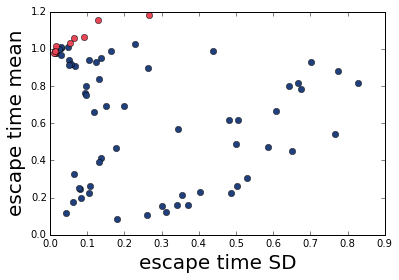

In [12]:
pareto_front_qrandom, non_pareto_front_qrandom, _ = find_pareto_efficient_mean_sd_vecs(*results_qrandom)
plot_pareto_frontier(pareto_front_qrandom, non_pareto_front_qrandom)

Here is how we can execute the weighted sum scalarization to produce a better approximate Pareto frontier in the same number of mean/variance estimations.

Before we can submit optimization requests to SigOpt, we must find our API token at http://www.sigopt.com/tokens.  You can also edit the `sigopt_maze_analysis.py` file to store your API token there, and make the appropriate modifications below, if you prefer.

In [ ]:
SIGOPT_API_TOKEN = 'FIND_YOUR_TOKEN_AT_THE_SIGOPT_WEBSITE'

In [14]:
weighted_sum_solver = SigOptMazeWeightedSumFrontierSolver(api_token=SIGOPT_API_TOKEN)
exp_dict_list = [
    {'mean_weight': .19, 'num_evals': 13, 'num_tests': num_tests},
    {'mean_weight': .43, 'num_evals': 14, 'num_tests': num_tests},
    {'mean_weight': .63, 'num_evals': 19, 'num_tests': num_tests},
    {'mean_weight': .87, 'num_evals': 24, 'num_tests': num_tests},
]

NOTE: Executing the following block will create 4 SigOpt experiments which will count towards your budgeted allotment.

In [15]:
results = weighted_sum_solver.execute_sigopt_weighted_sum_frontier_search(exp_dict_list, True)

Experiment 0: id 38, Info {'num_tests': 100, 'mean_weight': 0.19, 'num_evals': 13}
Experiment 1: id 39, Info {'num_tests': 100, 'mean_weight': 0.43, 'num_evals': 14}
Experiment 2: id 40, Info {'num_tests': 100, 'mean_weight': 0.63, 'num_evals': 19}
Experiment 3: id 41, Info {'num_tests': 100, 'mean_weight': 0.87, 'num_evals': 24}


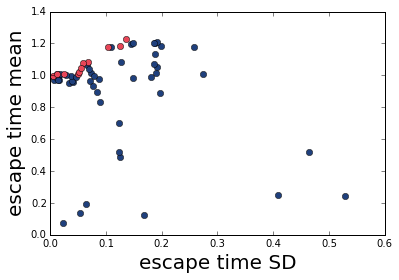

In [16]:
pareto_front, non_pareto_front, parameters_for_pareto_front = find_pareto_efficient_mean_sd_vecs(*results)
plot_pareto_frontier(pareto_front, non_pareto_front)

Here is how we can execute the constraint-based scalarization to approximate the Pareto frontier.

In [4]:
constraint_solver = SigOptMazeConstraintFrontierSolver(api_token=SIGOPT_API_TOKEN)
exp_dict_list = [
    {'mean_constraint': .95, 'num_evals': 24, 'num_tests': num_tests},
    {'mean_constraint': 1.0, 'num_evals': 20, 'num_tests': num_tests},
    {'mean_constraint': 1.02, 'num_evals': 15, 'num_tests': num_tests},
    {'mean_constraint': 1.04, 'num_evals': 11, 'num_tests': num_tests},
]

NOTE: Executing the following block will create 4 SigOpt experiments which will count towards your budgeted allotment.

In [5]:
results = constraint_solver.execute_sigopt_constraint_frontier_search(exp_dict_list, True)

Experiment 0: id 34, Info {'mean_constraint': 0.95, 'num_evals': 26, 'num_tests': 99}
Experiment 1: id 35, Info {'mean_constraint': 1.0, 'num_evals': 21, 'num_tests': 98}
Experiment 2: id 36, Info {'mean_constraint': 1.02, 'num_evals': 17, 'num_tests': 108}
Experiment 3: id 37, Info {'mean_constraint': 1.04, 'num_evals': 12, 'num_tests': 97}


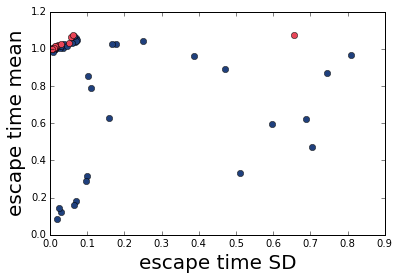

In [6]:
pareto_front, non_pareto_front, parameters_for_pareto_front = find_pareto_efficient_mean_sd_vecs(*results)
plot_pareto_frontier(pareto_front, non_pareto_front)

The below block can be used (with enough time) to recreate the 4 bar graphs which represent the empirical mass function for specific parametrization choices.

Notice that `num_tests` is used here (as it was earlier) to define the number of experiments for a given parametrization to understand the associated distribution.

In [21]:
from sigopt_maze_analysis import plot_hist_prop
from maze_tools import RightTurnSolver

def run_many_tests(num_tests, prob, verbose=True):
    num_points_searched = []
    rts = RightTurnSolver()
    for i in range(num_tests):
        if verbose and (i % 1000 == 0):
            print i
        rts.generate_random_maze(30, 30, prob=prob)
        rts.solve()
        num_points_searched.append(len(rts.path) / float(rts.shape[0] * rts.shape[1]))
    return num_points_searched

num_tests = 5000
num_points_searched_even = run_many_tests(num_tests, prob=(1, 1, 1, 1))
num_points_searched_highL = run_many_tests(num_tests, prob=(5, 1, 1, 1))
num_points_searched_highU = run_many_tests(num_tests, prob=(1, 5, 1, 1))
num_points_searched_highR = run_many_tests(num_tests, prob=(1, 1, 5, 1))

0
1000
2000
3000
4000
0
1000
2000
3000
4000
0
1000
2000
3000
4000
0
1000
2000
3000
4000


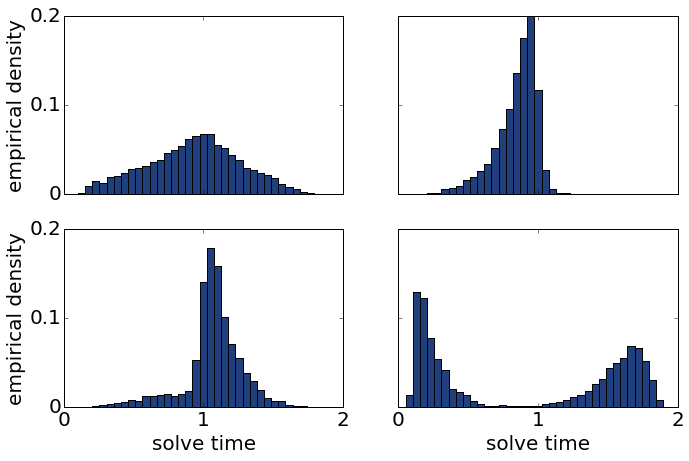

In [24]:
import numpy
from matplotlib import pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 7))
bin_num = 40
ax1.bar(*plot_hist_prop(num_points_searched_even, bins=numpy.linspace(0, 2, bin_num)), color="#1F407D");
ax2.bar(*plot_hist_prop(num_points_searched_highL, bins=numpy.linspace(0, 2, bin_num)), color="#1F407D");
ax3.bar(*plot_hist_prop(num_points_searched_highU, bins=numpy.linspace(0, 2, bin_num)), color="#1F407D");
ax4.bar(*plot_hist_prop(num_points_searched_highR, bins=numpy.linspace(0, 2, bin_num)), color="#1F407D");

fs = 20
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim((0, 2))
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels([0, 1, 2], ['0', '1', '2'], fontsize=fs)
    ax.set_ylim((0, .2))
    ax.set_yticks([0, .1, .2])
    ax.set_yticklabels([0, .1, .2], ['0', '.1', '.2'], fontsize=fs)
plt.setp([ax1.get_xticklabels(), ax2.get_xticklabels()], visible=False);
plt.setp([ax2.get_yticklabels(), ax4.get_yticklabels()], visible=False);
ax3.set_xlabel('solve time', fontsize=fs);
ax4.set_xlabel('solve time', fontsize=fs);
ax1.set_ylabel('empirical density', fontsize=fs);
ax3.set_ylabel('empirical density', fontsize=fs);

This code can be executed to show (with some randomness of course) some of the results on the Pareto frontier as revealed in the post along with the estimated mean and standard deviation (through computations mirroring those above).

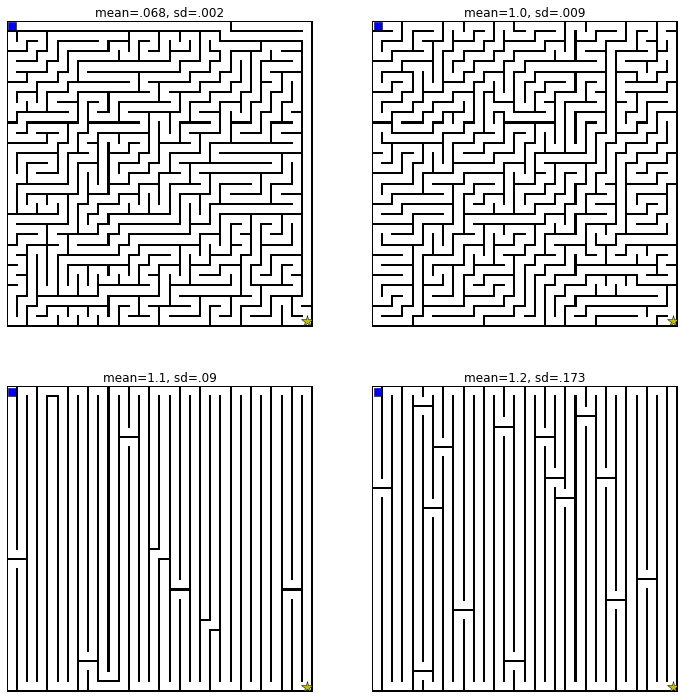

In [27]:
from maze_tools import RightTurnSolver
rts = RightTurnSolver()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

rts.generate_random_maze(30, 30, prob=(.034, .021, 88.365, 1.0))
rts.plot_maze(ax=ax1, markersize=8)
ax1.set_title('mean=.068, sd=.002')

rts.generate_random_maze(30, 30, prob=(51.4, 51.3, 1.385, 1.0))
rts.plot_maze(ax=ax2, markersize=8)
ax2.set_title('mean=1.0, sd=.009')

rts.generate_random_maze(30, 30, prob=(.015, 5.85, .0196, 1.0))
rts.plot_maze(ax=ax3, markersize=8)
ax3.set_title('mean=1.1, sd=.09')

rts.generate_random_maze(30, 30, prob=(.042, 61.226, .052, 1.0))
rts.plot_maze(ax=ax4, markersize=8)
ax4.set_title('mean=1.2, sd=.173');

Within the RightTurnSolver object, there are also tools available to recreate the images that make up the gifs in the post, but the specific code to create those gifs is omitted here to minimize tedium.